In [1]:
import duckdb as dd
from duckdb import DuckDBPyConnection
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

### Staging Tabelle

In [2]:
connect = dd.connect("data\\warehouse.duckdb")

In [9]:
connect.execute(
    "CREATE OR REPLACE TABLE staging_data AS " \
    "SELECT * FROM read_csv_auto('data\\example.csv')")

In [10]:
connect.sql("select * from staging_data limit 5")

┌─────────────────────┬─────────────┬────────────┬───────────┬─────────┬────────────┬───────────────┬──────────────────┬────────────────────┬────────┬────────────────┬──────────────┬───────────────────────┐
│    Purchase date    │ Customer ID │ First_Name │ Last_Name │ Gender  │  Birthday  │ Support Level │       City       │    Servicename     │ Costs  │ payment_method │ Sales Canal  │ Customer Satisfaction │
│      timestamp      │    int64    │  varchar   │  varchar  │ varchar │    date    │    varchar    │     varchar      │      varchar       │ double │    varchar     │   varchar    │         int64         │
├─────────────────────┼─────────────┼────────────┼───────────┼─────────┼────────────┼───────────────┼──────────────────┼────────────────────┼────────┼────────────────┼──────────────┼───────────────────────┤
│ 2011-05-12 13:48:47 │  3537994773 │ Lisa       │ Jones     │ F       │ 1920-03-03 │ Premium       │ New Sean         │ Databases          │   9.99 │ SEPA           │ on s

In [11]:
connect.sql("describe select * from staging_data limit 5")

┌───────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│      column_name      │ column_type │  null   │   key   │ default │  extra  │
│        varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Purchase date         │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ Customer ID           │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ First_Name            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Last_Name             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Gender                │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Birthday              │ DATE        │ YES     │ NULL    │ NULL    │ NULL    │
│ Support Level         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ City                  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Servicename           │ VARCHAR     │ 

### Erste kleine Analysen
Es geht um das Kennenlernen der Daten. Die Abfragen beantworten erste Annahmen. 

In [12]:
# Wie viele unterschiedliche Kunden gibt es?
query = """
SELECT 
  count(DISTINCT "Customer ID") as Anzahl
FROM staging_data  
"""
connect.sql(query)

┌────────┐
│ Anzahl │
│ int64  │
├────────┤
│    100 │
└────────┘

In [13]:
# Wie oft kommen die 7 Services vor?
query = """
SELECT
  Servicename,
  count(Servicename) as Anzahl
FROM staging_data
GROUP BY Servicename
ORDER BY Anzahl DESC
"""
connect.sql(query)

┌────────────────────┬────────┐
│    Servicename     │ Anzahl │
│      varchar       │ int64  │
├────────────────────┼────────┤
│ Bi Tooling         │  14346 │
│ Databases          │  14337 │
│ Automation         │  14324 │
│ E-Commerce         │  14302 │
│ Custom Development │  14286 │
│ Streaming          │  14217 │
│ Hardware           │  14188 │
└────────────────────┴────────┘

In [14]:
# Welche Services haben wir?
# einmalige Services und ihre Kosten. ROW_Number() nummeriert durch
query = """
WITH cte AS (
SELECT DISTINCT
  Servicename,
  Costs
FROM staging_data
GROUP BY Servicename, Costs
ORDER BY Costs)
SELECT 
  ROW_NUMBER() OVER () AS ID,
  Servicename, 
  Costs
FROM CTE
"""
connect.sql(query)

┌───────┬────────────────────┬────────┐
│  ID   │    Servicename     │ Costs  │
│ int64 │      varchar       │ double │
├───────┼────────────────────┼────────┤
│     1 │ Bi Tooling         │   8.99 │
│     2 │ Databases          │   9.99 │
│     3 │ Hardware           │  12.69 │
│     4 │ Streaming          │  19.99 │
│     5 │ E-Commerce         │  39.99 │
│     6 │ Automation         │  89.99 │
│     7 │ Custom Development │ 199.99 │
└───────┴────────────────────┴────────┘

In [15]:
# Die Abfrage macht nur Sinn wenn der Preis sich ändern würde. Das ist hier nicht der Fall
query = """
SELECT DISTINCT
  Servicename,
  AVG(Costs)
FROM staging_data
GROUP BY Costs, Servicename
ORDER BY Costs
"""
connect.sql(query)

┌────────────────────┬────────────────────┐
│    Servicename     │     avg(Costs)     │
│      varchar       │       double       │
├────────────────────┼────────────────────┤
│ Bi Tooling         │  8.990000000002238 │
│ Databases          │  9.990000000001302 │
│ Hardware           │ 12.690000000001799 │
│ Streaming          │ 19.989999999996037 │
│ E-Commerce         │  39.98999999999335 │
│ Automation         │  89.98999999999187 │
│ Custom Development │ 199.99000000005313 │
└────────────────────┴────────────────────┘

In [16]:
# Anzahl der Verkäufe pro Jahr
query = """
SELECT 
  EXTRACT(YEAR FROM "Purchase date") AS Year,
  COUNT(*) as Verkäufe
FROM staging_data
GROUP BY Year
ORDER BY Year
"""
connect.sql(query)

┌───────┬──────────┐
│ Year  │ Verkäufe │
│ int64 │  int64   │
├───────┼──────────┤
│  2010 │     6336 │
│  2011 │     6357 │
│  2012 │     6256 │
│  2013 │     6351 │
│  2014 │     6247 │
│  2015 │     6315 │
│  2016 │     6278 │
│  2017 │     6373 │
│  2018 │     6251 │
│  2019 │     6232 │
│  2020 │     6278 │
│  2021 │     6307 │
│  2022 │     6289 │
│  2023 │     6258 │
│  2024 │     6137 │
│  2025 │     5735 │
├───────┴──────────┤
│     16 rows      │
└──────────────────┘

In [17]:
# Verteilung auf Monate
query = """
SELECT
  STRFTIME("Purchase date", '%Y-%m') AS Jahr_Monat,
  COUNT(*) as Verkäufe
FROM staging_data
GROUP BY Jahr_Monat
ORDER BY Verkäufe DESC
LIMIT 10
"""
connect.sql(query)

┌────────────┬──────────┐
│ Jahr_Monat │ Verkäufe │
│  varchar   │  int64   │
├────────────┼──────────┤
│ 2017-01    │      589 │
│ 2023-08    │      578 │
│ 2023-12    │      578 │
│ 2022-07    │      576 │
│ 2010-08    │      576 │
│ 2015-07    │      576 │
│ 2021-12    │      572 │
│ 2013-12    │      572 │
│ 2015-05    │      572 │
│ 2020-07    │      572 │
├────────────┴──────────┤
│ 10 rows     2 columns │
└───────────────────────┘

In [18]:
# Verteilung auf Wochen
query = """
SELECT
  STRFTIME("Purchase date", '%Y-%W') AS Jahr_Woche,
  COUNT(*) as Verkäufe
FROM staging_data
GROUP BY Jahr_Woche
ORDER BY Verkäufe DESC
LIMIT 10
"""
connect.sql(query)

┌────────────┬──────────┐
│ Jahr_Woche │ Verkäufe │
│  varchar   │  int64   │
├────────────┼──────────┤
│ 2018-18    │      165 │
│ 2013-39    │      158 │
│ 2012-11    │      156 │
│ 2021-48    │      149 │
│ 2012-43    │      149 │
│ 2010-04    │      148 │
│ 2022-18    │      147 │
│ 2010-32    │      146 │
│ 2017-45    │      146 │
│ 2025-23    │      146 │
├────────────┴──────────┤
│ 10 rows     2 columns │
└───────────────────────┘

### Dimensionstabellen erstellen

In [19]:
# Services
query = """
CREATE OR REPLACE TABLE tblServices AS
WITH cte AS (
SELECT DISTINCT
  Servicename,
  Costs
FROM staging_data
ORDER BY Costs)
SELECT 
  ROW_NUMBER() OVER () AS service_id,
  Servicename, 
  Costs
FROM CTE
"""
connect.sql(query)

In [20]:
# Customers
query = """
CREATE OR REPLACE TABLE tblCustomers AS
SELECT DISTINCT
  "Customer ID" as customer_id,
  First_Name,
  Last_Name,
  Gender,
  City,
  "Support Level" as support_level,
  Birthday,
  date_diff('year', Birthday, today()) as Age
FROM staging_data
ORDER BY Last_Name
"""
connect.sql(query)

In [21]:
connect.sql("select * from tblCustomers where customer_id = '3114143559'")

┌─────────────┬────────────┬───────────┬─────────┬─────────┬───────────────┬──────────┬───────┐
│ customer_id │ First_Name │ Last_Name │ Gender  │  City   │ support_level │ Birthday │  Age  │
│    int64    │  varchar   │  varchar  │ varchar │ varchar │    varchar    │   date   │ int64 │
├─────────────┴────────────┴───────────┴─────────┴─────────┴───────────────┴──────────┴───────┤
│                                           0 rows                                            │
└─────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
query = """
CREATE OR REPLACE TABLE tblOrders AS
SELECT 
  ROW_NUMBER () OVER () as order_id,
  sd."Purchase date" as purchase_date,
  c.customer_id,
  s.service_id,
  sd.payment_method,
  sd."Sales Canal" as sales_canal,
  sd."Customer Satisfaction" as satisfaction
FROM 
  staging_data sd
JOIN tblCustomers c ON sd."Customer ID" = c.customer_id
JOIN tblServices s ON sd.Servicename = s.Servicename
"""
connect.sql(query)

### Tabellen überprüfen

In [23]:
connect.sql("select * from tblOrders limit 5")

┌──────────┬─────────────────────┬─────────────┬────────────┬────────────────┬──────────────┬──────────────┐
│ order_id │    purchase_date    │ customer_id │ service_id │ payment_method │ sales_canal  │ satisfaction │
│  int64   │      timestamp      │    int64    │   int64    │    varchar     │   varchar    │    int64     │
├──────────┼─────────────────────┼─────────────┼────────────┼────────────────┼──────────────┼──────────────┤
│        1 │ 2011-05-12 13:48:47 │  3537994773 │          2 │ SEPA           │ on site      │            3 │
│        2 │ 2013-07-21 12:12:58 │  2679998177 │          6 │ Kreditkarte    │ on site      │            2 │
│        3 │ 2015-09-25 21:26:49 │  5192981949 │          2 │ Kreditkarte    │ on site      │            3 │
│        4 │ 2019-04-15 00:57:59 │  1995792947 │          7 │ SEPA           │ online       │            1 │
│        5 │ 2018-05-02 01:13:33 │  8175175358 │          2 │ Kreditkarte    │ by telephone │            2 │
└──────────┴───────

In [24]:
# Alle Daten wieder zusammensetzen. 
query = """
SELECT 
  purchase_date,
  first_name,
  last_name,
  gender,
  support_level,
  city,
  servicename,
  payment_method,
  satisfaction
FROM
  tblOrders o
JOIN tblCustomers c ON o.customer_id = c.customer_id
JOIN tblServices s ON s.service_id = o.service_id
LIMIT 10
"""
connect.sql(query)

┌─────────────────────┬────────────┬───────────┬─────────┬───────────────┬───────────────────┬────────────────────┬────────────────┬──────────────┐
│    purchase_date    │ First_Name │ Last_Name │ Gender  │ support_level │       City        │    Servicename     │ payment_method │ satisfaction │
│      timestamp      │  varchar   │  varchar  │ varchar │    varchar    │      varchar      │      varchar       │    varchar     │    int64     │
├─────────────────────┼────────────┼───────────┼─────────┼───────────────┼───────────────────┼────────────────────┼────────────────┼──────────────┤
│ 2011-05-12 13:48:47 │ Lisa       │ Jones     │ F       │ Premium       │ New Sean          │ Databases          │ SEPA           │            3 │
│ 2013-07-21 12:12:58 │ Jacqueline │ Marshall  │ F       │ Standard      │ Dawnton           │ Automation         │ Kreditkarte    │            2 │
│ 2015-09-25 21:26:49 │ Vincent    │ Morgan    │ F       │ Premium       │ East Rebecca      │ Databases        

In [25]:
connect.sql("SELECT COUNT(DISTINCT customer_id) FROM tblCustomers;")

┌─────────────────────────────┐
│ count(DISTINCT customer_id) │
│            int64            │
├─────────────────────────────┤
│                         100 │
└─────────────────────────────┘

In [26]:
connect.sql("SELECT COUNT(DISTINCT servicename) FROM tblServices;")

┌─────────────────────────────┐
│ count(DISTINCT servicename) │
│            int64            │
├─────────────────────────────┤
│                           7 │
└─────────────────────────────┘

In [27]:
# haben wir Customer doppelt in der tblCustomers?
query = """
  SELECT
    customer_id,
    COUNT(*) as counter
  FROM tblCustomers c
  GROUP BY c.customer_id
  HAVING counter > 1
"""
connect.sql(query)

┌─────────────┬─────────┐
│ customer_id │ counter │
│    int64    │  int64  │
├─────────────┴─────────┤
│        0 rows         │
└───────────────────────┘

In [28]:
connect.sql("SELECT COUNT(DISTINCT customer_id) FROM tblCustomers;")


┌─────────────────────────────┐
│ count(DISTINCT customer_id) │
│            int64            │
├─────────────────────────────┤
│                         100 │
└─────────────────────────────┘

In [29]:
connect.sql("SELECT COUNT(DISTINCT service_id) FROM tblServices;")

┌────────────────────────────┐
│ count(DISTINCT service_id) │
│           int64            │
├────────────────────────────┤
│                          7 │
└────────────────────────────┘

In [30]:
connect.sql("SELECT COUNT(DISTINCT order_id) FROM tblOrders;")

┌──────────────────────────┐
│ count(DISTINCT order_id) │
│          int64           │
├──────────────────────────┤
│                   100000 │
└──────────────────────────┘

### Analyse
Hier werden die Daten ausgewertet. 

In [31]:
# Wie viele Bestellungen gibt es insgesamt?
query = """
SELECT 
  COUNT(*) as total_orders
FROM tblOrders
"""
connect.sql(query)

┌──────────────┐
│ total_orders │
│    int64     │
├──────────────┤
│       100000 │
└──────────────┘

In [32]:
# Welches Jahr war das Umsatzstärkste?
query = """
SELECT 
  SUM(s.costs) as in_total,
  count(o.purchase_date) as in_total_orders,
  extract('year' FROM o.purchase_date) as year
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY year
ORDER BY in_total desc
"""
connect.sql(query)


┌────────────────────┬─────────────────┬───────┐
│      in_total      │ in_total_orders │ year  │
│       double       │      int64      │ int64 │
├────────────────────┼─────────────────┼───────┤
│   353025.989999974 │            6251 │  2018 │
│  352480.1699999742 │            6373 │  2017 │
│ 349494.14999997534 │            6315 │  2015 │
│  345902.9199999757 │            6258 │  2023 │
│  345114.8399999754 │            6256 │  2012 │
│  344200.4099999756 │            6289 │  2022 │
│  341936.2899999758 │            6351 │  2013 │
│ 340528.32999997475 │            6307 │  2021 │
│  340459.8199999761 │            6278 │  2016 │
│   339716.329999975 │            6357 │  2011 │
│  339165.6399999764 │            6336 │  2010 │
│ 338347.32999997627 │            6137 │  2024 │
│  338187.7799999752 │            6232 │  2019 │
│  337320.8199999759 │            6278 │  2020 │
│  334331.7299999768 │            6247 │  2014 │
│ 314239.04999998055 │            5735 │  2025 │
├───────────────────

### Das stärkste Jahr grafisch

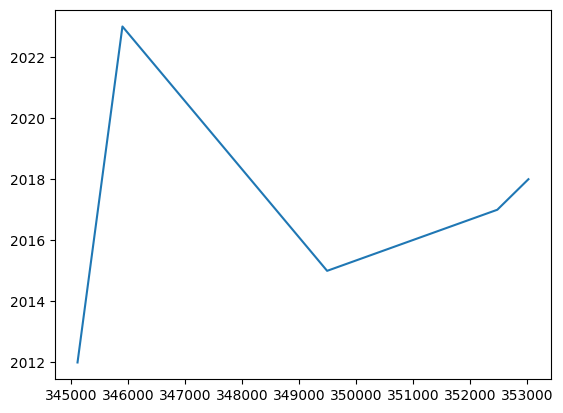

In [33]:
query = """
SELECT 
  SUM(s.costs) as in_total,
  extract('year' FROM o.purchase_date) as year
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY year
ORDER BY in_total desc
LIMIT 5
"""
df = connect.execute(query).df()
plt.plot(df['in_total'], df['year'])

In [34]:
# Welcher Service ist der beliebteste?
query = """
SELECT 
  count(s.service_id) as in_total,
  s.Servicename
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY o.service_id, s.Servicename
ORDER BY in_total desc
"""
connect.sql(query)

┌──────────┬────────────────────┐
│ in_total │    Servicename     │
│  int64   │      varchar       │
├──────────┼────────────────────┤
│    14346 │ Bi Tooling         │
│    14337 │ Databases          │
│    14324 │ Automation         │
│    14302 │ E-Commerce         │
│    14286 │ Custom Development │
│    14217 │ Streaming          │
│    14188 │ Hardware           │
└──────────┴────────────────────┘

### Der beliebteste Service grafisch

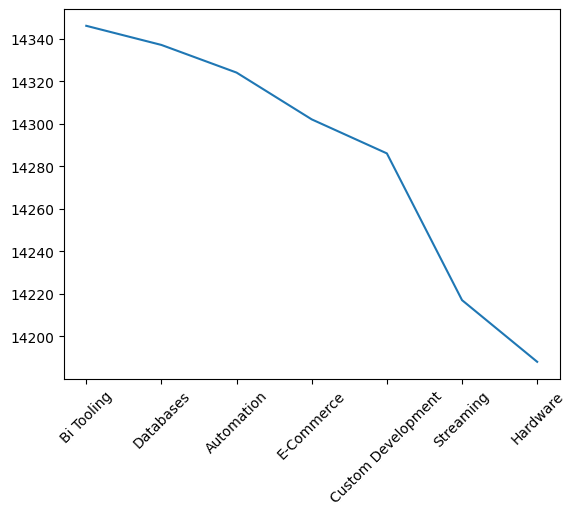

In [35]:
query = """
SELECT 
  count(s.service_id) as in_total,
  s.Servicename
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY o.service_id, s.Servicename
ORDER BY in_total desc
"""
df = connect.query(query).df()
plt.xticks(rotation=45)
plt.plot(df['Servicename'], df['in_total'])

In [36]:
# Welcher Service ist der Beliebteste aber mit Window Functions. 
query = """
SELECT DISTINCT
  s.Servicename
  ,COUNT() OVER (PARTITION BY s.Servicename) as Counter
FROM tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
ORDER BY Counter desc
LIMIT 7
"""
connect.sql(query)

┌────────────────────┬─────────┐
│    Servicename     │ Counter │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Bi Tooling         │   14346 │
│ Databases          │   14337 │
│ Automation         │   14324 │
│ E-Commerce         │   14302 │
│ Custom Development │   14286 │
│ Streaming          │   14217 │
│ Hardware           │   14188 │
└────────────────────┴─────────┘

### Kundenverhalten

In [37]:
# Wer sind die Top 5 Kunden?
query = """
SELECT
  customer_id,
  count(*) as order_count
FROM tblOrders
GROUP BY customer_id
ORDER BY order_count desc
LIMIT 5
"""
connect.sql(query)

┌─────────────┬─────────────┐
│ customer_id │ order_count │
│    int64    │    int64    │
├─────────────┼─────────────┤
│  2679998177 │        1000 │
│  6531963213 │        1000 │
│  2821448128 │        1000 │
│  9932797979 │        1000 │
│  3773768842 │        1000 │
└─────────────┴─────────────┘

### Fürs Dashboard

In [38]:
# Anzahl der Bestellungen einer Stadt
def get_city_profit(city: str, con: DuckDBPyConnection) -> pd.DataFrame:
    query = """
    SELECT 
      s.servicename,
      count(s.servicename) as counter,
      sum(s.costs) as total_costs
    FROM 
      tblOrders o
    JOIN tblCustomers c ON o.customer_id = c.customer_id
    JOIN tblServices s ON o.service_id = s.service_id
    WHERE c.City = $city
    GROUP BY s.servicename
    ORDER BY total_costs DESC
    """
    result = con.execute(query, {'city': city}).df()
    return result


In [39]:
def get_city_profit_per_year(city: str, con: DuckDBPyConnection) -> pd.DataFrame:
    # Anzahl der Verkäufe pro Jahr
    query = """
    SELECT 
    EXTRACT(YEAR FROM purchase_date) AS Year,
    COUNT(*) as Verkäufe
    FROM tblOrders o
    JOIN tblCustomers c ON c.customer_id = o.customer_id
    WHERE c.City = $city
    GROUP BY Year
    """
    return con.execute(query, {"city": city}).df()

In [8]:
# Welcher Service ist der beliebteste?
query = """
SELECT 
  count(s.service_id) as in_total,
  s.Servicename
FROM 
  tblOrders o
JOIN tblServices s ON o.service_id = s.service_id
GROUP BY o.service_id, s.Servicename
ORDER BY in_total desc
"""
df = connect.execute(query).df()
fig = px.pie(df, values='in_total', names='Servicename')
fig.show()

In [9]:
connect.close()